# make numpy array for training

In [1]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable

In [2]:
#f_rnd = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/LHC-Olympics/Code/Nsubjettiness_mjj.h5")

In [3]:
prong_2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [18]:
dt = prong_2.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


In [19]:
j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.088
tau32prime = tau32 + rhoprime * 0.025
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.001

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.086
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

In [20]:
dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

In [21]:
X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

In [22]:
#dt = f_rnd.values

In [23]:
X.shape

(516804, 14)

In [24]:
sig_mean = []
sig_std = []
for i in range(14):
    mean = np.mean(X[:,i])
    std = np.std(X[:,i])
    sig_mean.append(mean)
    sig_std.append(std)
    X[:,i] = (X[:,i]-mean)/std

In [25]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [26]:
X.shape

(516804, 14)

In [27]:
y = idx

In [28]:
y.shape

(516804,)

# Normalize Inputs

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(
#    X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

In [31]:
print(X_train.shape, X_val.shape, X_test.shape)

(413443, 14) (51680, 14) (51681, 14)


In [32]:
class trainData(utils.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class testData(utils.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [33]:
train_data = trainData(torch.FloatTensor(X_train.astype(np.float)),torch.FloatTensor(y_train.astype(np.float)))
val_data = trainData(torch.FloatTensor(X_val.astype(np.float)),torch.FloatTensor(y_val.astype(np.float)))
test_data = testData(torch.FloatTensor(X_test.astype(np.float))) 

# Make Dataloader

In [34]:
import torch

In [35]:
torch.cuda.is_available()

True

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [37]:
BATCH_SIZE = 1000
N_EPOCHS = 80
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

# NN classifier

In [38]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(14,84)
        self.linear2 = nn.Linear(84,42)
        self.linear3 = nn.Linear(42,21)
        self.linear4 = nn.Linear(21,10)
        self.linear5 = nn.Linear(10,5)
        self.linear_out = nn.Linear(5,1)
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(84)
        self.batchnorm2 = nn.BatchNorm1d(42)
        self.batchnorm3 = nn.BatchNorm1d(21)
        self.batchnorm4 = nn.BatchNorm1d(10)
        self.batchnorm5 = nn.BatchNorm1d(5)
        

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchnorm1(self.linear1(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm2(self.linear2(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm3(self.linear3(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm4(self.linear4(x))
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.batchnorm5(self.linear5(x))
        x = F.leaky_relu(x)
        x = self.linear_out(x)
        return x





In [39]:
model = Net()

print(model)
model.to(device)

Net(
  (linear1): Linear(in_features=14, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Net(
  (linear1): Linear(in_features=14, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=42, bias=True)
  (linear3): Linear(in_features=42, out_features=21, bias=True)
  (linear4): Linear(in_features=21, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=5, bias=True)
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [56]:
# optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [57]:
device

device(type='cuda', index=0)

In [58]:
train_loader = utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = utils.DataLoader(dataset=val_data, batch_size=100)
test_loader = utils.DataLoader(dataset=test_data, batch_size=100)

In [59]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [60]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    epoch_loss = 0
    epoch_acc = 0

    for x, y in train_loader:
        # reshape the data into [batch_size, 784]
        x,y = x.to(device), y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        y_pred = model(x)

        # reconstruction loss
        #recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        #loss = recon_loss + kl_loss

        #BCE loss
        loss = criterion(y_pred, y.unsqueeze(1))
        acc = binary_acc(y_pred, y.unsqueeze(1))
        
        # backward pass
        loss.backward()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # update the weights
        optimizer.step()

    return epoch_loss


In [61]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, y in val_loader:
            # reshape the data
            #x = x.view(-1, 28 * 28)
            x,y = x.to(device), y.to(device)
            # forward pass
            y_pred = model(x)

            loss = criterion(y_pred, y.unsqueeze(1))
            acc = binary_acc(y_pred, y.unsqueeze(1))
            # total loss
            
            test_loss += loss.item()

    return test_loss

In [65]:
best_test_loss = float('inf')

for e in range(100):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_data)
    test_loss /= len(val_data)

    print(f'Epoch {e}, Train Loss: {train_loss:.7f}, Test Loss: {test_loss:.7f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/fully_connected_ref_tauDDT_14inputs_on_2prong.h5")
        patience_counter = 1
        print('saving model')
    else:
        print('NOT SAVING')
        patience_counter += 1

    if patience_counter > 10:
        print('patience limit reached')
        break

Epoch 0, Train Loss: 0.0001881, Test Loss: 0.0017880
saving model
Epoch 1, Train Loss: 0.0001883, Test Loss: 0.0017877
saving model
Epoch 2, Train Loss: 0.0001882, Test Loss: 0.0017883
NOT SAVING
Epoch 3, Train Loss: 0.0001881, Test Loss: 0.0018008
NOT SAVING
Epoch 4, Train Loss: 0.0001878, Test Loss: 0.0017906
NOT SAVING
Epoch 5, Train Loss: 0.0001881, Test Loss: 0.0017916
NOT SAVING
Epoch 6, Train Loss: 0.0001882, Test Loss: 0.0017890
NOT SAVING
Epoch 7, Train Loss: 0.0001884, Test Loss: 0.0017884
NOT SAVING
Epoch 8, Train Loss: 0.0001879, Test Loss: 0.0018201
NOT SAVING
Epoch 9, Train Loss: 0.0001877, Test Loss: 0.0017911
NOT SAVING
Epoch 10, Train Loss: 0.0001881, Test Loss: 0.0017883
NOT SAVING
Epoch 11, Train Loss: 0.0001878, Test Loss: 0.0017966
NOT SAVING
patience limit reached


In [67]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/fully_connected_ref_tauDDT_14inputs_on_2prong.h5"))

<All keys matched successfully>

In [174]:
prong_3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")

In [175]:
dt = prong_3.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.088
tau32prime = tau32 + rhoprime * 0.025
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.001

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.086
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

In [ ]:
def get_tpr_fpr_2d_new(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.linspace(0,10000,10000)
    bins_bkgae = np.linspace(0,50,501)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        compare = -0.1
        tpr_temp = 0
        fpr_temp = 0 
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            if fpr_t == 0:
                fpr_t = 1000000000
            ratio = tpr_t/fpr_t
            if ratio > compare:
                compare = ratio
                tpr_temp = tpr_t
                fpr_temp = fpr_t
        tpr.append(tpr_temp)
        fpr.append(fpr_temp)
                

    return tpr,fpr 

In [176]:
X_wrongprior = X

X.shape

wrongprior_data = testData(torch.FloatTensor(X_wrongprior.astype(np.float))) 
wrongprior_loader = utils.DataLoader(dataset=wrongprior_data, batch_size=100)

y_wrongpriorlist = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(wrongprior_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_wrongpriorlist = np.append(y_wrongpriorlist,y_test_pred.cpu().numpy())
        

len(y_wrongpriorlist)

78223

In [68]:
model.eval()
y_pred_list = np.array([],dtype=np.float)
with torch.no_grad():
    for batch_idx, X_batch in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list,y_test_pred.cpu().numpy())
        


In [69]:
truesig = np.where(y_test==1)
truebkg = np.where(y_test==0)
sigscore = y_pred_list[truesig]
bkgscore = y_pred_list[truebkg]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00119119, 0.00178678, 0.00119119, 0.00506254,
        0.01042287, 0.01727219, 0.02501489, 0.04883859, 0.04228708,
        0.05926147, 0.11882073, 0.10810006, 0.15425849, 0.1777844 ,
        0.14026206, 0.20905301, 0.17272186, 0.13430613, 0.18493151,
        0.15038714, 0.1131626 , 0.07027993, 0.03275759, 0.01697439,
        0.00327576, 0.00059559, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([-10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,  -6. ,
         -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,  -1.5,
         -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,
          3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,
          8. ,   8.5,   9. ,   9.5]),
 <a list of 39 Patch objects>)

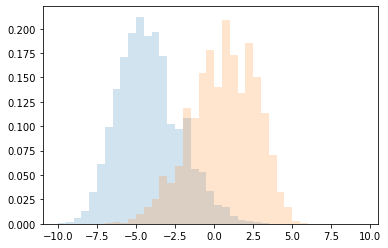

In [70]:
plt.hist(bkgscore,bins=np.arange(-10,10,.5),alpha=.2,density=True)
plt.hist(sigscore,bins=np.arange(-10,10,.5),alpha=.2,density=True)
#plt.hist(y_wrongpriorlist,bins=np.arange(-10,10,.5),alpha=0.2,density=True)


In [76]:
def get_tpr_fpr_supervised(sigloss,bkgloss):
    bins = np.arange(-20,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return tpr,fpr

In [78]:
sup_tpr, sup_fpr = get_tpr_fpr_supervised(sigscore,bkgscore)

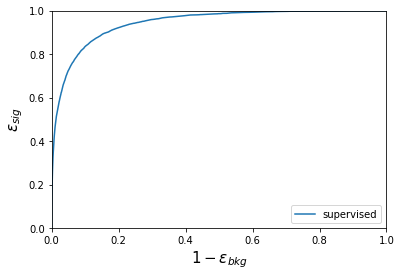

In [79]:
plt.plot(sup_fpr,sup_tpr,label='supervised')
#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_optimalcase_approaches_FULLYSUPERVISED.png')

In [125]:
bkgae_bkgloss = np.load('../data_strings/bkg_rndbkg_tauDDTwithm1andm1minusm2_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_Justloss_rndbkg.npy')
bkgae_sigloss = np.load('../data_strings/bkg_rndbkg_tauDDTwithm1andm1minusm2_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_Justloss_2prong.npy')

In [152]:
sigae_sigloss = np.load('../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_2prong.npy')
sigae_bkgloss = np.load('../data_strings/sig_2prong_tauDDTwithoutrawmass_turnoncutandj1sdbcut0p9_MSELoss_beta1_z6f10_Justloss_rndbkg.npy')

In [153]:
def get_tpr_fpr_bkg(sigloss,bkgloss):
    bins = np.arange(0,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))

    return fpr,tpr

In [154]:
def get_tpr_fpr_sig(sigloss,bkgloss):
    bins = np.arange(0,20,.01)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))

    return fpr,tpr

In [155]:
bkgae_fpr, bkgae_tpr = get_tpr_fpr_bkg(bkgae_sigloss,bkgae_bkgloss)

In [156]:
sigae_fpr, sigae_tpr = get_tpr_fpr_sig(sigae_sigloss,sigae_bkgloss)

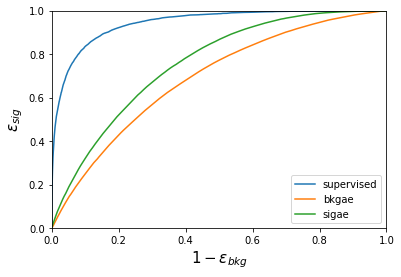

In [157]:
plt.plot(sup_fpr,sup_tpr,label='supervised')
plt.plot(bkgae_fpr,bkgae_tpr,label='bkgae')
plt.plot(sigae_fpr,sigae_tpr,label='sigae')
#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.savefig('ROC_optimalcase_approaches_FULLYSUPERVISED.png')

In [158]:
def get_tpr_fpr_2d_new(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,0,.1)
    bins_bkgae = np.arange(0,0,.1)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        compare = -0.1
        tpr_temp = 0
        fpr_temp = 0 
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            
            if fpr_t == 0:
                fpr_t = 1000000000
            ratio = tpr_t/fpr_t
            
            if sigcut == 1.0 and bkgcut==1.0:
                print(tpr_t,fpr_t,ratio)
                
            if ratio > compare:
                compare = ratio
                tpr_temp = tpr_t
                fpr_temp = fpr_t
        tpr.append(tpr_temp)
        fpr.append(fpr_temp)
                

    return tpr,fpr  

In [133]:
scan_tpr, scan_fpr = get_tpr_fpr_2d_new(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss)

0.21253533552998793 0.01684692970121687 12.61567177517434


KeyboardInterrupt: 

In [144]:
def get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,100,.1)
    bins_bkgae = np.arange(0,100,.1)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            tpr.append(tpr_t)
            fpr.append(fpr_t)
                

    return tpr,fpr

In [159]:
scan_tpr, scan_fpr = get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss)

In [160]:
from scipy.spatial import ConvexHull

In [161]:
points = np.array([scan_fpr,scan_tpr])

In [162]:
points = points.transpose()

In [163]:
hull = ConvexHull(points)

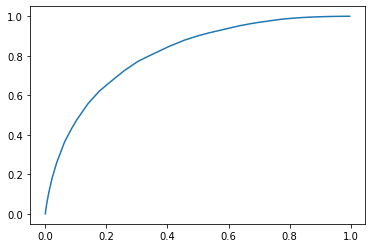

In [164]:
plt.plot(points[hull.vertices[2:],0], points[hull.vertices[2:],1])

In [ ]:
plt.plot(sup_fpr,sup_tpr,label='supervised')
plt.plot(bkgae_fpr,bkgae_tpr,label='bkgae')
plt.plot(sigae_fpr,sigae_tpr,label='sigae')
plt.plot(points[hull.vertices[2:],0], points[hull.vertices[2:],1], 'b--', lw=2,label='2dscan with complete signal')
#plt.plot(justlossfpr5t,justlosstpr5t,label='MSE_5taus')
#plt.plot(VAE_bkg_40var_fpr,VAE_bkg_40var_tpr,label='Bkg VAE-Vanilla_40var')
#plt.plot(betaVAE_bkg_fpr,betaVAE_bkg_tpr,label='Bkg betaVAE')

plt.xlabel(r'$1-\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='lower right')
plt.xlim([0.0,.1])
plt.ylim([0.0,1.0])
plt.savefig('ROC_optimalcase_approaches_FULLYSUPERVISED.png')

In [222]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



In [223]:
mass = dt[:,0]

(array([9.00000e+00, 5.58000e+02, 9.20300e+03, 3.67500e+04, 6.77230e+04,
        1.03113e+05, 8.39410e+04, 7.20000e+04, 6.31530e+04, 4.19920e+04,
        1.34320e+04, 5.51500e+03, 1.85400e+03, 3.30000e+02, 2.90000e+01,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9]),
 <a list of 19 Patch objects>)

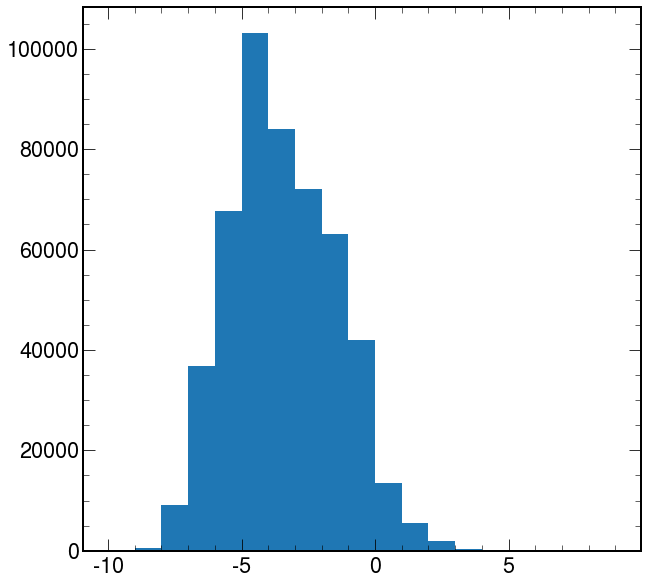

In [224]:
plt.hist(y_bb, bins=np.arange(-10,10,1))

In [225]:
len(np.where(y_bb>2.3)[0])

1399

In [226]:
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

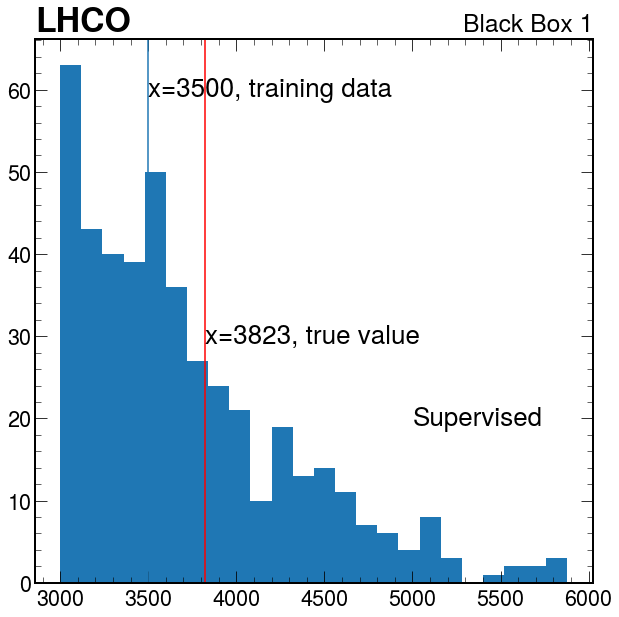

In [227]:
plt.hist(mass[y_bb>2.5], bins=np.arange(3000,6000,120))
plt.axvline(x=3500)
plt.text(3500, 60, "x=3500, training data",  verticalalignment='center')

plt.axvline(x=3823,color='r')

plt.text(3823, 30, "x=3823, true value",  verticalalignment='center')

plt.text(5000, 20, "Supervised",  verticalalignment='center')
hep.label.lumitext("Black Box 1")
label_base._exp_text("LHCO")
plt.savefig('bb1_supervised.png')


In [263]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



In [264]:
mass = dt[:,0]

plt.hist(mass[y_bb>3.4], bins=np.arange(3000,6000,150))
plt.axvline(x=3500)
plt.text(3500, 20, "x=3500, training data",  verticalalignment='center')

#plt.axvline(x=3823,color='r')

#plt.text(3823, 15, "True value unknown",  verticalalignment='center')

plt.text(5000, 10, "Supervised",  verticalalignment='center')
hep.label.lumitext("Black Box 2")
label_base._exp_text("LHCO")
plt.savefig('bb2_supervised.png')

In [277]:
bb1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")

dt = bb1.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#Y = dt[:,[4,5,6,7,8,11,12,13,14,15,16,17,18,20,21,22,23,24,27,28,29,30,31,32,33,34]] # When no jet 1,2 raw mass included
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
idx = dt[:,-1]
#bkg_idx = np.where(idx==0)[0]
#signal_idx = np.where((idx==1) & (dt[:,3]>300))[0]
##signal_idx = np.where((idx==1)) [0]
#dt = dt[signal_idx]
    
bsmlike = np.where(dt[:,16]>0.9)[0]
dt = dt[bsmlike]


dt.shape

j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.0775
tau32prime = tau32 + rhoprime * 0.027
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.004

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.088
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

dt.shape

X = dt[:,[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

for i in range(14):
    X[:,i] = (X[:,i]-sig_mean[i])/sig_std[i]

X_bb = X

X_bb.shape

bb_data = testData(torch.FloatTensor(X_bb.astype(np.float))) 
bb_loader = utils.DataLoader(dataset=bb_data, batch_size=100)

y_bb = []
with torch.no_grad():
    for batch_idx, X_batch in enumerate(bb_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_bb = np.append(y_bb,y_test_pred.cpu().numpy())
        



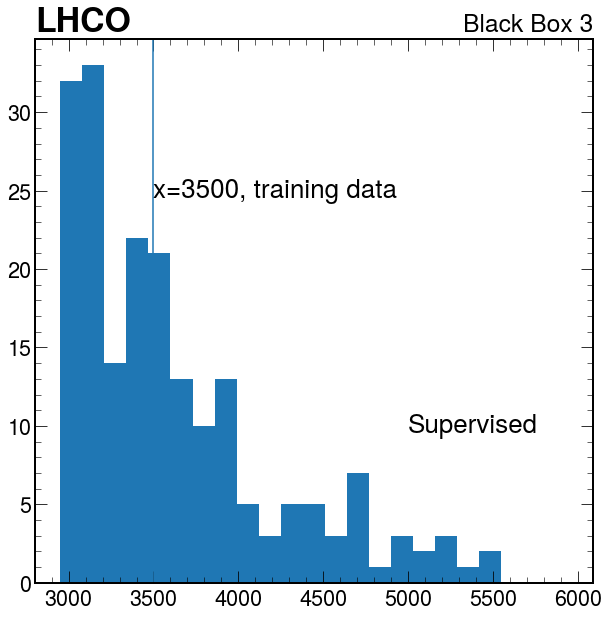

In [318]:
mass = dt[:,0]

plt.hist(mass[y_bb>2.1], bins=np.arange(2950,6000,130))
plt.axvline(x=3500)


plt.text(3500, 25, "x=3500, training data",  verticalalignment='center')

#plt.axvline(x=3823,color='r')

#plt.text(3823, 15, "True value unknown",  verticalalignment='center')

plt.text(5000, 10, "Supervised",  verticalalignment='center')



hep.label.lumitext("Black Box 3")
label_base._exp_text("LHCO")
plt.savefig('bb3_supervised.png')

In [142]:
sigscore.shape

(6716,)

In [143]:
print(sigscore)

[-0.71345681 -0.68024683  2.09297943 ... -4.48688602  3.87274647
  3.30166578]


In [70]:
bkgscore.shape

(99844,)

In [71]:
print(y_pred_list.shape,y_test.shape)
print(y_pred_list[:20],y_test[:20])

(110000,) (110000,)
[6.01285370e-03 1.40656037e-02 6.33050862e-04 9.06132385e-02
 4.29636799e-03 2.59291963e-04 2.91777588e-03 9.88843734e-04
 1.93072669e-03 2.13927981e-02 2.22644396e-03 3.17776599e-03
 7.99695496e-03 6.96382206e-03 3.63481743e-03 5.33045316e-03
 5.50930796e-04 1.47437686e-02 5.34979522e-01 2.88454480e-02] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [86]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    
    return tpr,fpr  

In [87]:
tpr, fpr = get_tpr_fpr(sigscore,bkgscore)

In [89]:
np.save('supervised_ref_tpr.npy',tpr)
np.save('supervised_ref_fpr.npy',fpr)

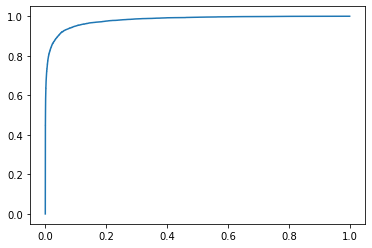

In [88]:
plt.plot(fpr,tpr)

In [77]:
max(0,1e-6)

1e-06

In [91]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,1,100001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            if (np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]) != 0:
                tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
                precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [92]:
precision, recall = get_precision_recall(sigscore,bkgscore)

In [94]:
np.save('supervised_ref_precision.npy',precision)
np.save('supervised_ref_recall.npy',recall)

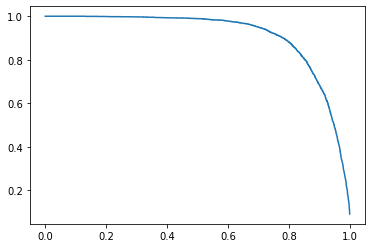

In [95]:
plt.plot(recall,precision)

# Now time to train a simple NN

In [ ]:
plt.hist(data_branches[b'vjet0_msd0'][y_pred_list>-40],1000)

In [ ]:
data

In [ ]:
f = uproot.update("data/JetHT_s.root")

In [ ]:
data   = uproot.open("data/JetHT_s.root")["Tree"]
data.extend({"NN_score":y_pred_list})

In [ ]:
import numpy as np

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

In [ ]:
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

In [ ]:
print(x.shape)

In [ ]:
# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

In [ ]:
learning_rate = 1e-6

In [ ]:
for i in range(500):
    #forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h,0)
    y_pred = h_relu.dot(w2)
    
    loss = np.square(y_pred-y).sum()
    print(t,loss)
    
    # back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2  = h_relu.T.dot(grad_y_pred)
    g
    
    
    